In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from science.utilities import options_utils
from utilities import utils
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Theta modeling

In [2]:
query = '''
    with
    i as (
      select distinct *
      from td.black_scholes
      where market_datetime = current_date - 1
        and symbol = 'KO'
        and put_call = 'True'
    )
    select distinct
        i.market_datetime
      , i.symbol
      , i.implied_volatility
      , i.strike
      , i.days_to_maturity
      , s.open as stock
      , (o.bid + o.ask) / 2 as current_option_price
    from i
    left join dbt.stocks as s
      on  i.symbol = s.symbol
      and i.market_datetime = s.market_datetime
    left join dbt.options as o
      on  i.symbol = o.symbol
      and i.market_datetime = o.file_datetime
      and i.strike = o.strike
      and i.days_to_maturity = o.days_to_expiration
      and o.put_call = 'CALL'
    order by i.days_to_maturity, i.strike
    '''
df = utils.query_db(query=query)
df.head(100)

,market_datetime,symbol,implied_volatility,strike,days_to_maturity,stock,current_option_price
0,2021-01-21,KO,3.060167,40.0,1.0,48.78,9.100
1,2021-01-21,KO,2.384334,42.0,1.0,48.78,7.050
2,2021-01-21,KO,1.874158,42.5,1.0,48.78,6.500
3,2021-01-21,KO,2.161597,43.5,1.0,48.78,5.550
4,2021-01-21,KO,1.628943,44.0,1.0,48.78,4.950
...,...,...,...,...,...,...,...
95,2021-01-21,KO,0.236957,53.0,15.0,48.78,0.045
96,2021-01-21,KO,0.268532,53.5,15.0,48.78,0.040
97,2021-01-21,KO,0.280332,54.0,15.0,48.78,0.040
98,2021-01-21,KO,0.301254,54.5,15.0,48.78,0.035


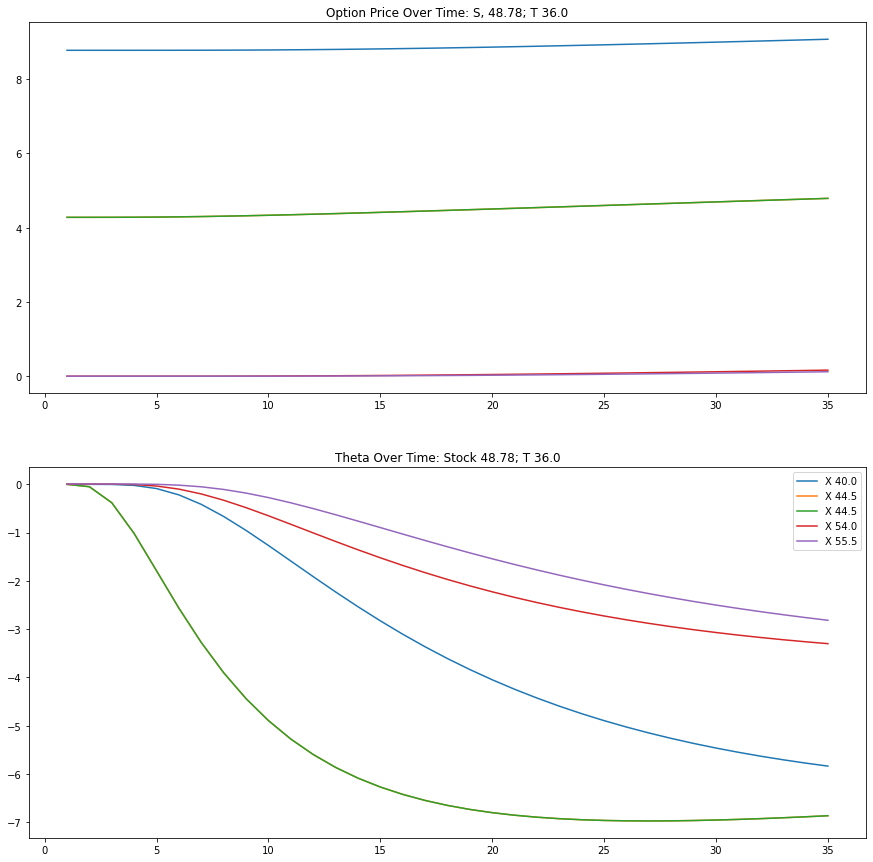

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

day = np.sort(df['days_to_maturity'].unique())[5]
x_strikes = np.random.choice(df.loc[df['days_to_maturity']==day, 'strike'].unique(), 5)
for strike in np.sort(x_strikes):
    x = df[(df['strike']==strike) & (df['days_to_maturity']==day)]
    days = []
    options = []
    thetas = []
    for d in range(1, int(day)):
        bs = options_utils.BlackScholes(
            stock=x['stock'].values[0],
            strike=x['strike'].values[0],
            days_to_maturity=d,
            volatility=x['implied_volatility'].values[0],
            risk_free_rate=.001,
        )
        days.append(d)
        options.append(bs.option_price)
        thetas.append(bs.theta)
    ax[0].set_title(f"Option Price Over Time: S, {df['stock'].values[0]}; T {day}")
    ax[0].plot(days, options, label=f'X {strike}')
    ax[1].set_title(f"Theta Over Time: Stock {df['stock'].values[0]}; T {day}")
    ax[1].plot(days, thetas, label=f'X {strike}')
plt.legend()
plt.show()